### Installation

In [1]:
%pip install niwrap styxsingularity


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Setting up the StyxRunner

In [ ]:
from styxdefs import set_global_runner
from styxsingularity import SingularityRunner

base = "/ocean/projects/med220004p/bshresth/projects/niwrap-dev"

# Initialize the SingularityRunner with your container images
runner = SingularityRunner(
    images={
        "antsx/ants:v2.5.3" : f"{base}/images/ants_v2.5.3.sif",
        "afni/afni_make_build:AFNI_24.2.06" : f"{base}/images/afni_24.2.06.sif",
        "mcin/fsl:6.0.5": f"{base}/images/fsl_6.0.5.sif"
    }
)

# Set the global runner for Styx
set_global_runner(runner)


### Anatomical Preprocessing

In [4]:
from niwrap import afni
import subprocess

def anat_init(input_image, orientation="RPI"):
    # Make a copy of input image and deoblique it
    subprocess.run(["cp", input_image, "T1w.nii.gz"])
    # Deoblique the image
    afni.v_3drefit(in_file="T1w.nii.gz", deoblique=True)
    # Resample the image to specific orientation
    out = afni.v_3dresample(in_file=input_image, orientation=orientation, prefix="desc-preproc_T1w.nii.gz")
    
    return out

### Input image

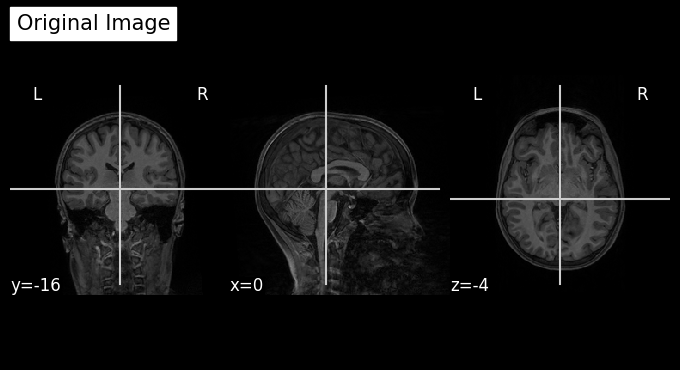

In [5]:
import os
from nilearn.plotting import plot_anat

input_image = "/ocean/projects/med220004p/bshresth/projects/flo_project/abcd-1subj/sub-NDARINV2VY7YYNW/ses-baselineYear1Arm1/anat/sub-NDARINV2VY7YYNW_ses-baselineYear1Arm1_run-01_T1w.nii"

plot_anat(input_image, title="Original Image", display_mode="ortho")

### Deoblique and resample the image

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/T1w.nii.gz:/styx_input/0/T1w.nii.gz --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_1_3drefit:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3drefit -deoblique /styx_input/0/T1w.nii.gz
[E] ++ 3drefit: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: RW Cox
[E] ++ Processing AFNI dataset /styx_input/0/T1w.nii.gz
[E]  + deoblique
[E]  + loading and re-writing dataset /styx_input/0/T1w.nii.gz (/styx_input/0/T1w.nii.gz in NIFTI storage)
[E] ++ 3drefit processed 1 datasets
[I] Executed 3drefit in 0:00:02.747361
[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/flo_project/abcd-1subj/sub-NDARINV2VY7YYNW/ses-baselineYear1Arm1/anat/sub-NDARINV2VY7YYNW_ses-baselin

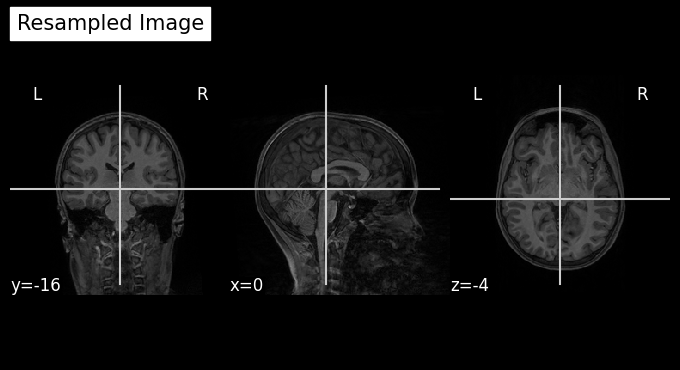

In [9]:
resampled = anat_init(input_image)
plot_anat(resampled.out_file, title="Resampled Image", display_mode="ortho")

### Skullstripping

In [12]:
from niwrap import fsl

def brain_mask_fsl(input_image):
    out = fsl.bet(infile=input_image, binary_mask=True)
    return out

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_2_3dresample/desc-preproc_T1w.nii.gz:/styx_input/0/desc-preproc_T1w.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_4_bet:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/fsl_6.0.5.sif /bin/bash /styx_output/run.sh
[D] Running command: bet /styx_input/0/desc-preproc_T1w.nii.gz img_bet -m


[I] Executed bet in 0:00:13.127398


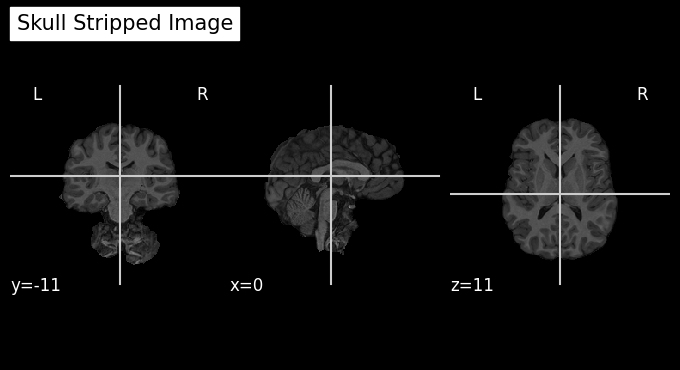

In [13]:
skull_stripped = brain_mask_fsl(resampled.out_file)
skull_stripped_image = skull_stripped.outfile

plot_anat(skull_stripped_image, title="Skull Stripped Image", display_mode="ortho")

Similarly we can use other tools

In [ ]:
# from nodeblocks.anat_preproc import brain_mask_ants
# template_path = os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz")
# mask_path=os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0_BrainCerebellumProbabilityMask.nii.gz")
# regmask_path =os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0_BrainCerebellumRegistrationMask.nii.gz")
# skull_stripped = brain_mask_ants(input_image, template_path, mask_path)
# skull_stripped_image = skull_stripped.brain_extracted_image

In [ ]:
### N4 Bias Field Correction Block ###
from niwrap import ants

def n4biasfieldcorrection(input_image):
    """N4BiasFieldCorrection -d 3 
    --input-image sub-PA001_ses-V1W1_acq-MPR_rec-Norm_T1w_resample.nii.gz 
    --output sub-PA001_ses-V1W1_acq-MPR_rec-Norm_T1w_resample_corrected.nii.gz 
    --shrink-factor 2
    """
    out = ants.n4_bias_field_correction(input_image=input_image, 
                                        corrected_image_path="corrected.nii.gz",
                                        image_dimensionality=3, 
                                        shrink_factor=2,
                                        bias_field_path="bias.nii.gz",
                                     )
    return out


anat_preproc = n4biasfieldcorrection(skull_stripped_image)

### Plotting the results ###
plot_anat(anat_preproc.corrected_image, title="Preproc_T1w_bet", display_mode="ortho")

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_4_bet/img_bet.nii.gz:/styx_input/0/img_bet.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_5_N4BiasFieldCorrection:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/ants_v2.5.3.sif /bin/bash /styx_output/run.sh
[D] Running command: N4BiasFieldCorrection --image-dimensionality 3 --shrink-factor 2 --input-image /styx_input/0/img_bet.nii.gz --output '[corrected.nii.gz,bias.nii.gz]'


### Functional Preprocessing

Lets define a averaging function to view the Mean of bold images.

In [ ]:
def average_bold(input_bold):
    out = afni.v_3d_tstat(mean=True, in_file=input_bold, prefix="desc-mean_sbref.nii.gz")
    return out

Setting the input bold

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/flo_project/abcd-1subj/sub-NDARINV2VY7YYNW/ses-baselineYear1Arm1/func/sub-NDARINV2VY7YYNW_ses-baselineYear1Arm1_task-rest_run-01_bold.nii:/styx_input/0/sub-NDARINV2VY7YYNW_ses-baselineYear1Arm1_task-rest_run-01_bold.nii:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/fb8de554fa949faf_0_3dTstat:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dTstat -mean -prefix desc-mean_sbref.nii.gz /styx_input/0/sub-NDARINV2VY7YYNW_ses-baselineYear1Arm1_task-rest_run-01_bold.nii


[E] ++ 3dTstat: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: KR Hammett & RW Cox
[E] ++ Output dataset ./desc-mean_sbref.nii.gz
[I] Executed 3dTstat in 0:00:15.104269


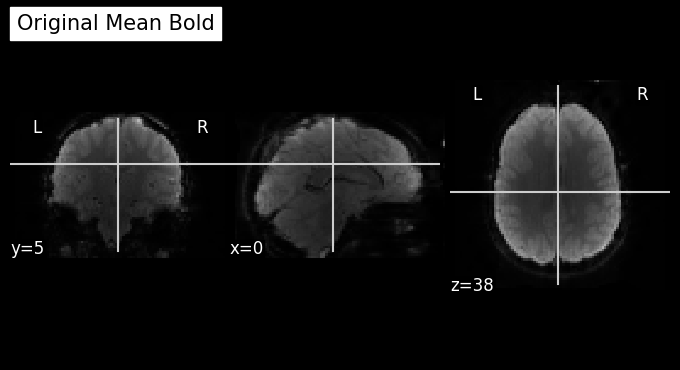

In [8]:
input_bold = "/ocean/projects/med220004p/bshresth/projects/flo_project/abcd-1subj/sub-NDARINV2VY7YYNW/ses-baselineYear1Arm1/func/sub-NDARINV2VY7YYNW_ses-baselineYear1Arm1_task-rest_run-01_bold.nii"
plot_anat(average_bold(input_bold).out_file, title="Original Mean Bold", display_mode="ortho")

### SkullStripping

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/data/neurocon/sub-control032014/func/sub-control032014_task-resting_run-1_bold.nii.gz:/styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/styx_tmp/b6b056e8b3a642c1_5_3dAutomask:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dAutomask -prefix desc-brain_mask_bold.nii.gz -apply_prefix desc-brain_bold.nii.gz /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz


[E] ++ 3dAutomask: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: Emperor Zhark
[E] *+ WARNING:   If you are performing spatial transformations on an oblique dset,
[E]   such as /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz,
[E]   or viewing/combining it with volumes of differing obliquity,
[E]   you should consider running: 
[E]      3dWarp -deoblique 
[E]   on this and  other oblique datasets in the same session.
[E]  See 3dWarp -help for details.
[E] ++ Oblique dataset:/styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz is 13.317834 degrees from plumb.
[E] ++ Loading dataset /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz
[E] ++ Forming automask
[E]  + Fixed clip level = 333.972382
[E]  + Used gradual clip level = 283.845459 .. 387.400604
[E]  + Number voxels above clip level = 16569
[E]  + Clustering voxels ...
[E]  + Largest cluster has 16477 voxels
[E]  + Clustering voxels ...
[E]  + Largest cluster has 16284 voxels

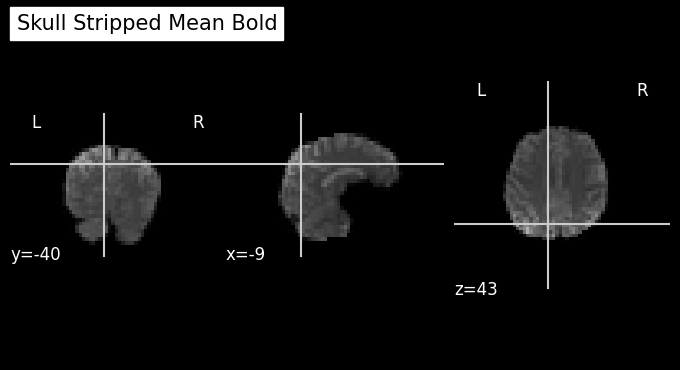

In [ ]:
def auto_mask(input_bold):
    out = afni.v_3d_automask(in_file=input_bold, apply_prefix="desc-brain_bold.nii.gz", prefix="desc-brain_mask_bold.nii.gz")
    return out

skull_stripped = auto_mask(input_bold)

average = average_bold(skull_stripped.brain_file)

plot_anat(average.out_file, title="Skull Stripped Mean Bold", display_mode="ortho")

### Motion Correction

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/styx_tmp/b6b056e8b3a642c1_6_3dTstat/desc-mean_sbref.nii.gz:/styx_input/0/desc-mean_sbref.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/styx_tmp/b6b056e8b3a642c1_5_3dAutomask/desc-brain_bold.nii.gz:/styx_input/1/desc-brain_bold.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/styx_tmp/b6b056e8b3a642c1_7_3dvolreg:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dvolreg -twopass -Fourier -base /styx_input/0/desc-mean_sbref.nii.gz -zpad 4 -prefix desc-mc_bold.nii.gz -maxdisp1d desc-mc_maxdisp_bold.1D /styx_input/1/desc-brain_bold.nii.gz


[E] ++ 3dvolreg: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: RW Cox
[E] *+ WARNING:   If you are performing spatial transformations on an oblique dset,
[E]   such as /styx_input/0/desc-mean_sbref.nii.gz,
[E]   or viewing/combining it with volumes of differing obliquity,
[E]   you should consider running: 
[E]      3dWarp -deoblique 
[E]   on this and  other oblique datasets in the same session.
[E]  See 3dWarp -help for details.
[E] ++ Oblique dataset:/styx_input/0/desc-mean_sbref.nii.gz is 13.317834 degrees from plumb.
[E] ++ Oblique dataset:/styx_input/1/desc-brain_bold.nii.gz is 13.317834 degrees from plumb.
[E] ++ Coarse del was 10, replaced with 3
[E] ++ Max displacement in automask = 0.52 (mm) at sub-brick 0
[E] ++ Max delta displ  in automask = 0.18 (mm) at sub-brick 8
[I] Executed 3dvolreg in 0:01:29.225492
[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/styx_tmp/b6b056e8b3a642c1_7_3dvolreg/desc-m

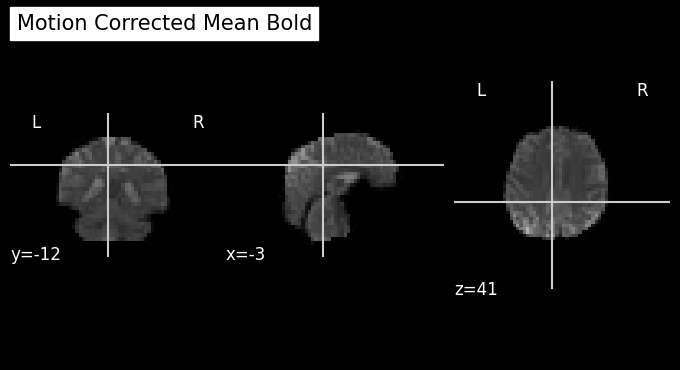

In [ ]:
def motion_correction(input_bold, base_file):
    out = afni.v_3dvolreg(in_file=input_bold, 
                          twopass=True,
                          fourier=True,
                          zpad=4,
                          basefile=base_file,
                          prefix="desc-mc_bold.nii.gz",
                          maxdisp1d="desc-mc_maxdisp_bold.1D")
    return out

mc = motion_correction(skull_stripped.brain_file, average.out_file)

plot_anat(average_bold(mc.out_file).out_file, title="Motion Corrected Mean Bold", display_mode="ortho")

In [ ]:
def flirt_registration(input_image, reference_image):
    out = fsl.flirt(in_file=input_image, 
                    reference=reference_image, 
                    cost="corratio",
                    interp="linear",
                    dof=6)
    return out

T1_space_bold = flirt_registration(input_image= mc.out_file, reference_image= anat_preproc.corrected_image)


plot_anat(average_bold(T1_space_bold.out_file).out_file, title="T1 Space Bold", display_mode="ortho")